# Data sampling and Image size reshaping

## Imports

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, classification_report
import pandas as pd
from keras.callbacks import Callback

## Reading statistics

In [2]:
stats = pd.read_csv("/kaggle/input/image-dimensions/image_dimensions.csv")
#stats = pd.read_csv("image_dimensions.csv")
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2797.000000,2797.000000
mean,603.319271,648.314623
std,415.975788,446.883172
min,106.000000,108.000000
25%,314.000000,383.000000
50%,550.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,550.000000,590.000000


## Helper functions

In [3]:
median_width = int(stats.loc["median", "widths"])
median_height = int(stats.loc["median", "heights"])

In [4]:
def build_model(width, height):
    model = keras.Sequential([
        layers.InputLayer(shape=(width, height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(256, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid'),
    ])
    return model

model = build_model(median_width, median_height)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 550, 590, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 548, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 272, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 134, 144, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 65, 70, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 33, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         253,441 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def plot_info(axes, type, ylabel):
    axes.set_title(type)
    axes.set_xlabel("Epochs")
    axes.set_ylabel(ylabel)
    axes.legend()
    axes.grid()

def plot_loss(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs_range = range(1, len(history.history["loss"]) + 1)

    _, axes = plt.subplots(4,1, figsize=(12,18))
    axes[0].plot(epochs_range, loss, label="Training loss")
    axes[0].plot(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[0], "Lineair", "Loss")
    

    axes[1].semilogy(epochs_range, loss, label="Training loss")
    axes[1].semilogy(epochs_range, val_loss, label="Validation loss")
    plot_info(axes[1], "Logarithmic", "Loss")

    axes[2].plot(epochs_range, acc, label="Training accuracy")
    axes[2].plot(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[2], "Lineair", "Loss")

    axes[3].semilogy(epochs_range, acc, label="Training accuracy")
    axes[3].semilogy(epochs_range, val_acc, label="Validation accuracy")
    plot_info(axes[3], "Logarithmic", "Loss")

In [6]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [7]:
def print_metrics(model, test):
    y_pred_prob = model.predict(test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

    auc_score = roc_auc_score(y_true, y_pred_prob)

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))
    print("ROC AUC: ", roc_auc_score(y_true, y_pred))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid()

In [8]:
class DynamicMetricsDisplayCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("loss")
        val_loss = logs.get("val_loss")
        accuracy = logs.get("accuracy")
        val_accuracy = logs.get("val_accuracy")
        print(f"Epoch {epoch + 1:02d}: loss = {loss:.4f}, val_loss = {val_loss:.4f}, "
              f"accuracy = {accuracy:.4f}, val_accuracy = {val_accuracy:.4f}")

In [9]:
class DynamicMetricsPlotCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

        # Set up the plot
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 5))
        self.ax[0].set_title("Loss")
        self.ax[0].set_xlabel("Epoch")
        self.ax[0].set_ylabel("Loss")
        self.ax[1].set_title("Accuracy")
        self.ax[1].set_xlabel("Epoch")
        self.ax[1].set_ylabel("Accuracy")
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch + 1)
        self.losses.append(logs.get("loss", 0))
        self.val_losses.append(logs.get("val_loss", 0))
        self.accuracies.append(logs.get("accuracy", 0))
        self.val_accuracies.append(logs.get("val_accuracy", 0))

        # Clear previous plots
        for ax in self.ax:
            ax.cla()

        # Update Loss Plot
        self.ax[0].plot(self.epochs, self.losses, label="Training Loss", marker="o")
        self.ax[0].plot(self.epochs, self.val_losses, label="Validation Loss", marker="o")
        self.ax[0].legend()

        # Update Accuracy Plot
        self.ax[1].plot(self.epochs, self.accuracies, label="Training Accuracy", marker="o")
        self.ax[1].plot(self.epochs, self.val_accuracies, label="Validation Accuracy", marker="o")
        self.ax[1].legend()

        # Redraw the plot
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs=None):
        plt.ioff()
        plt.show()

## Undersampled dataset

### Model trainen

In [10]:
painters = ["Mondriaan", "Picasso"]
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
# dataset_dir = "undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_width, median_height)
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss")]
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 600ms/step - accuracy: 0.5656 - loss: 2.6498 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.4867 - loss: 0.6973 - val_accuracy: 0.4902 - val_loss: 0.6732
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5294 - loss: 0.7332 - val_accuracy: 0.5000 - val_loss: 0.6686
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5309 - loss: 0.8181 - val_accuracy: 0.5196 - val_loss: 0.7303
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6109 - loss: 0.6692 - val_accuracy: 0.6863 - val_loss: 0.6910
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5311 - loss: 0.7065 - val_accuracy: 0.6275 - val_loss: 0.6284
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5208 - loss: 0.7052 - val_accuracy: 0.5784 - 

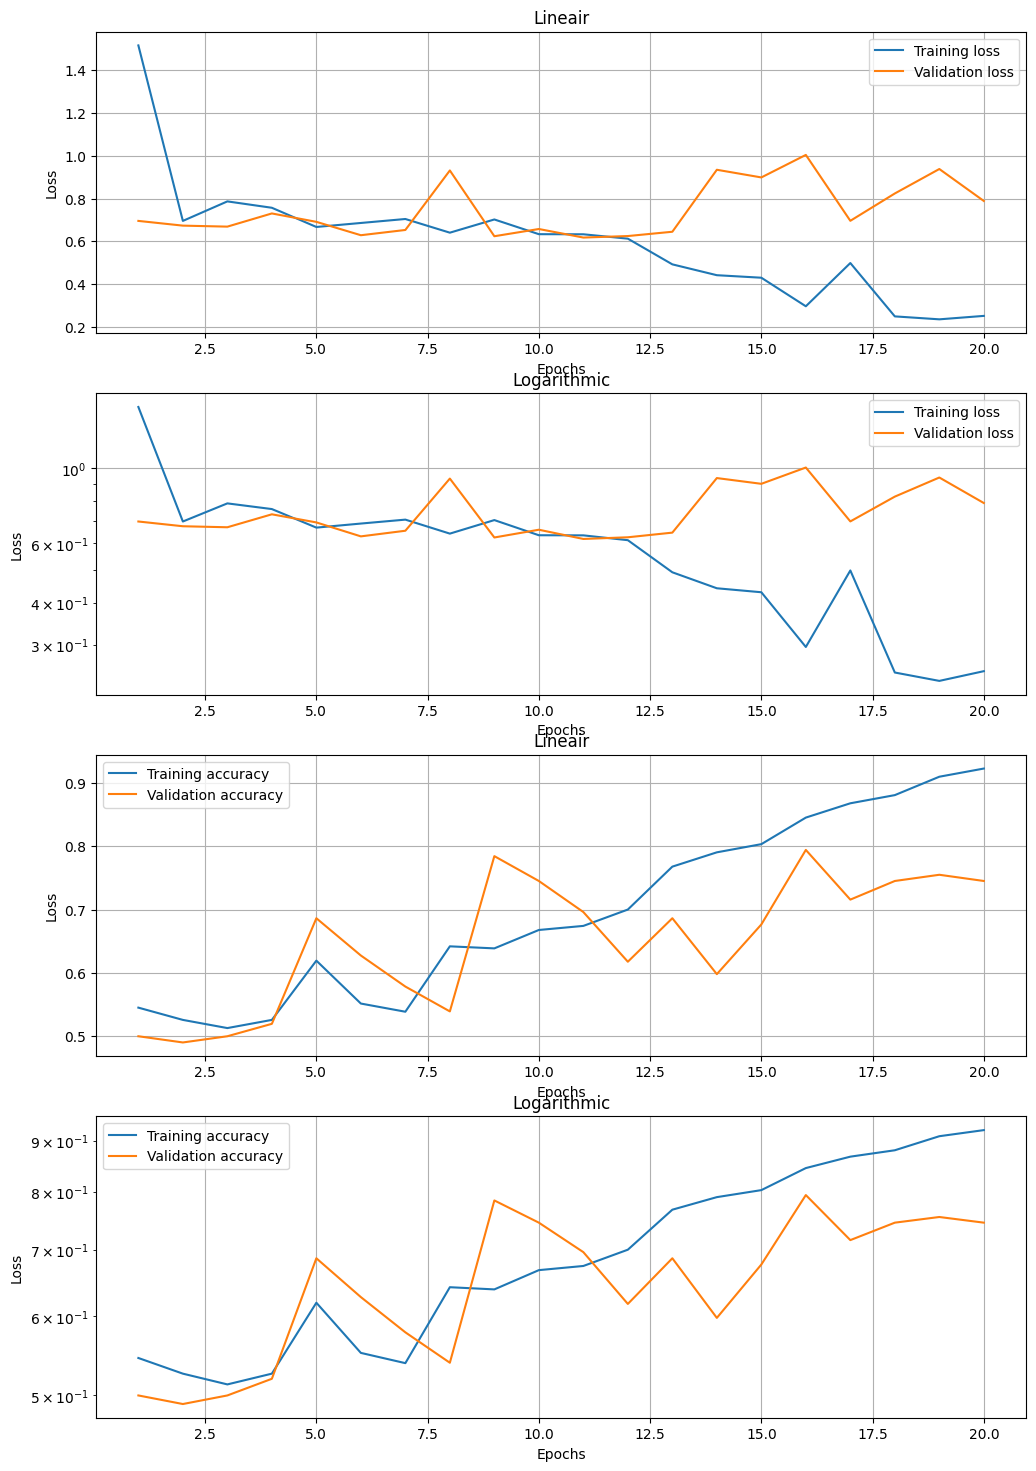

In [11]:
plot_loss(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy:  0.47058823529411764
Recall:  0.49019607843137253
Precision:  0.4716981132075472
F1:  0.4807692307692308
ROC AUC:  0.47058823529411764


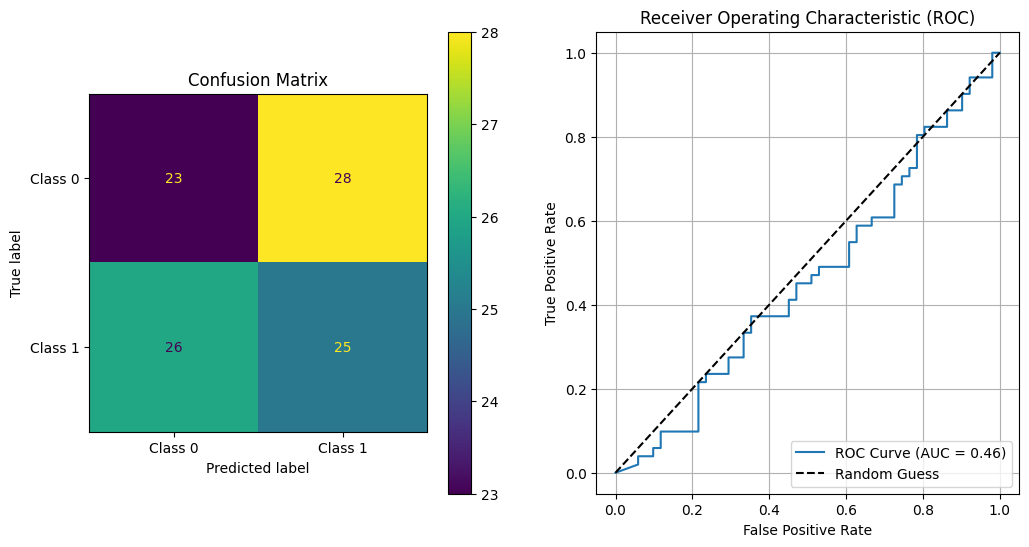

In [12]:
print_metrics(model, test)

## Oversampled dataset

### loading data en model trainen

In [13]:
# dataset_dir = "oversampled_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/oversampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, median_height, median_width, batch_size=16)
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_oversampled.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks)

Found 1834 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Found 610 files belonging to 2 classes.
Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.5477 - loss: 1.3821 - val_accuracy: 0.6410 - val_loss: 0.6651
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.5901 - loss: 0.6722 - val_accuracy: 0.7279 - val_loss: 0.5446
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.7390 - loss: 0.6047 - val_accuracy: 0.6705 - val_loss: 0.5488
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.8367 - loss: 0.4299 - val_accuracy: 0.7557 - val_loss: 0.5729
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.8941 - loss: 0.2990 - val_accuracy: 0.8984 - val_loss: 0.3302
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9425 - loss: 0.1536 - val_accuracy: 0.9311 - val_loss: 0.4012
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - accuracy: 0.9749 - loss: 0.0830 - va

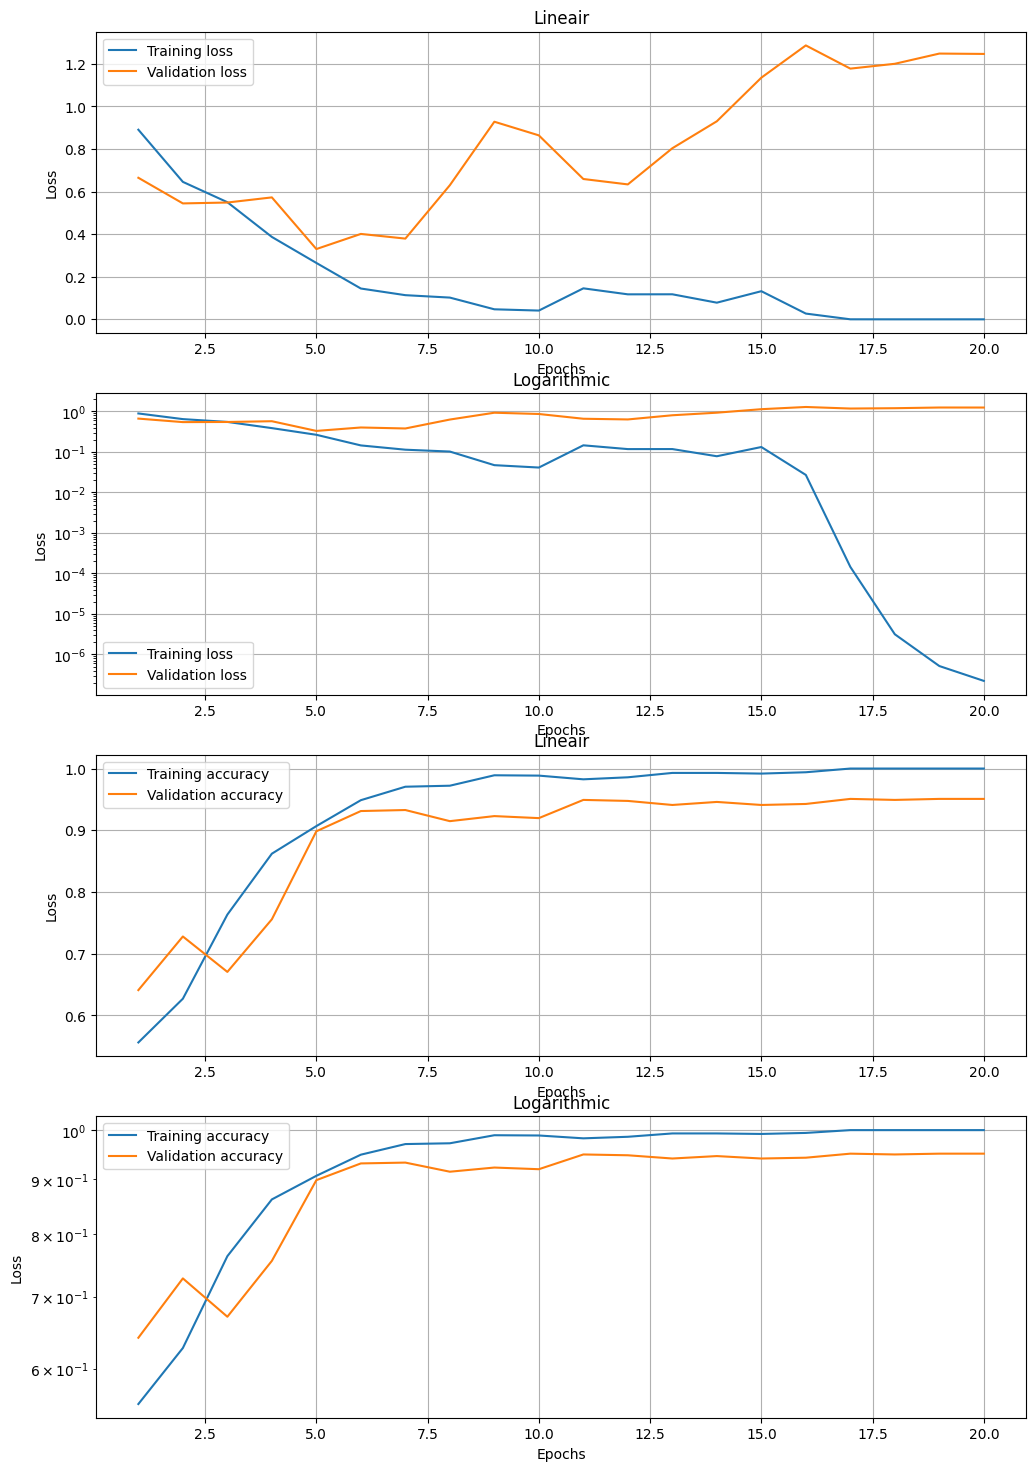

In [14]:
plot_loss(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Accuracy:  0.5163934426229508
Recall:  0.4885245901639344
Precision:  0.5173611111111112
F1:  0.5025295109612142
ROC AUC:  0.5163934426229508


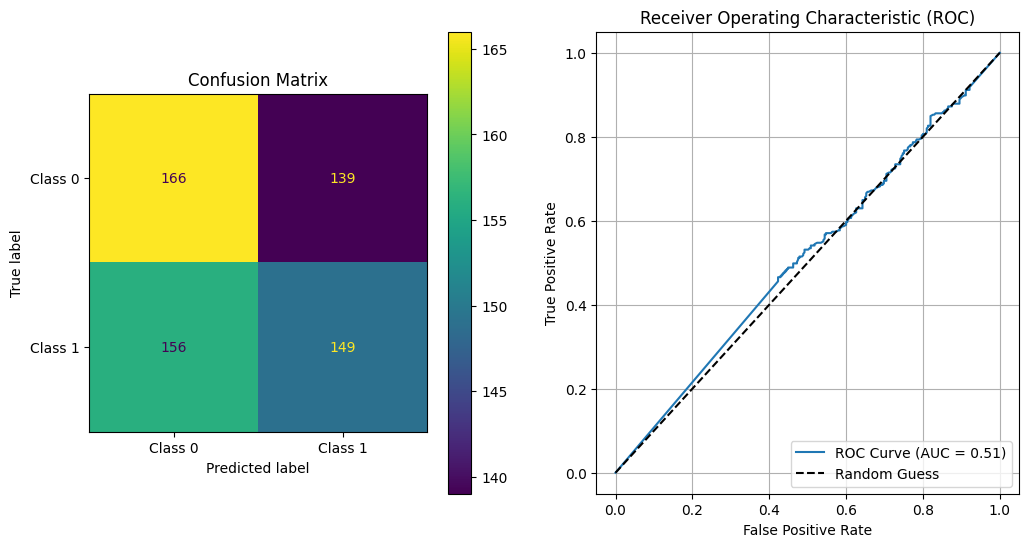

In [15]:
print_metrics(model, test)

## imbalanced dataset

### loading dataset

In [16]:
train, val, test = load_dataset("/kaggle/input/schilderijen-datasets/imbalanced_dataset", painters, median_width, median_height, batch_size=16)

Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


### Fitting model 

#### Class weights bepalen

Mondriaan = 0, Picasso = 1

In [17]:
train.class_names

['Mondriaan', 'Picasso']

In [18]:
class_counts = {}

for _, labels in train:
    for label in labels.numpy():
        class_counts[label] = class_counts.get(label, 0) + 1

total = sum(class_counts.values())
total, class_counts

(1115, {1: 917, 0: 198})

Model trainen

In [19]:
mondriaan_count = class_counts.get(0, 0)  
picasso_count = class_counts.get(1, 0)   

weight_for_0 = float((1 / mondriaan_count) * (total / 2.0)) if mondriaan_count > 0 else 0
weight_for_1 = float((1 / picasso_count) * (total / 2.0)) if picasso_count > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}

class_weight

{0: 2.8156565656565657, 1: 0.6079607415485279}

In [20]:
model = build_model(median_width, median_height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath="model_imbalanced.keras", save_best_only=True, monitor="val_loss")]
model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.4967 - loss: 1.9487 - val_accuracy: 0.8257 - val_loss: 0.5139
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6702 - loss: 0.7242 - val_accuracy: 0.8284 - val_loss: 0.6450
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6542 - loss: 0.7136 - val_accuracy: 0.7962 - val_loss: 0.4482
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.6419 - loss: 0.6884 - val_accuracy: 0.5684 - val_loss: 0.9709
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6720 - loss: 0.6560 - val_accuracy: 0.6702 - val_loss: 0.5589
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.6716 - loss: 0.5720 - val_accuracy: 0.8391 - val_loss: 0.3532
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.7505 - loss: 0.5498 - val_accuracy: 0.6220 - val_loss: 0.6316
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.7676 - loss: 0.4416 - val_accuracy: 0

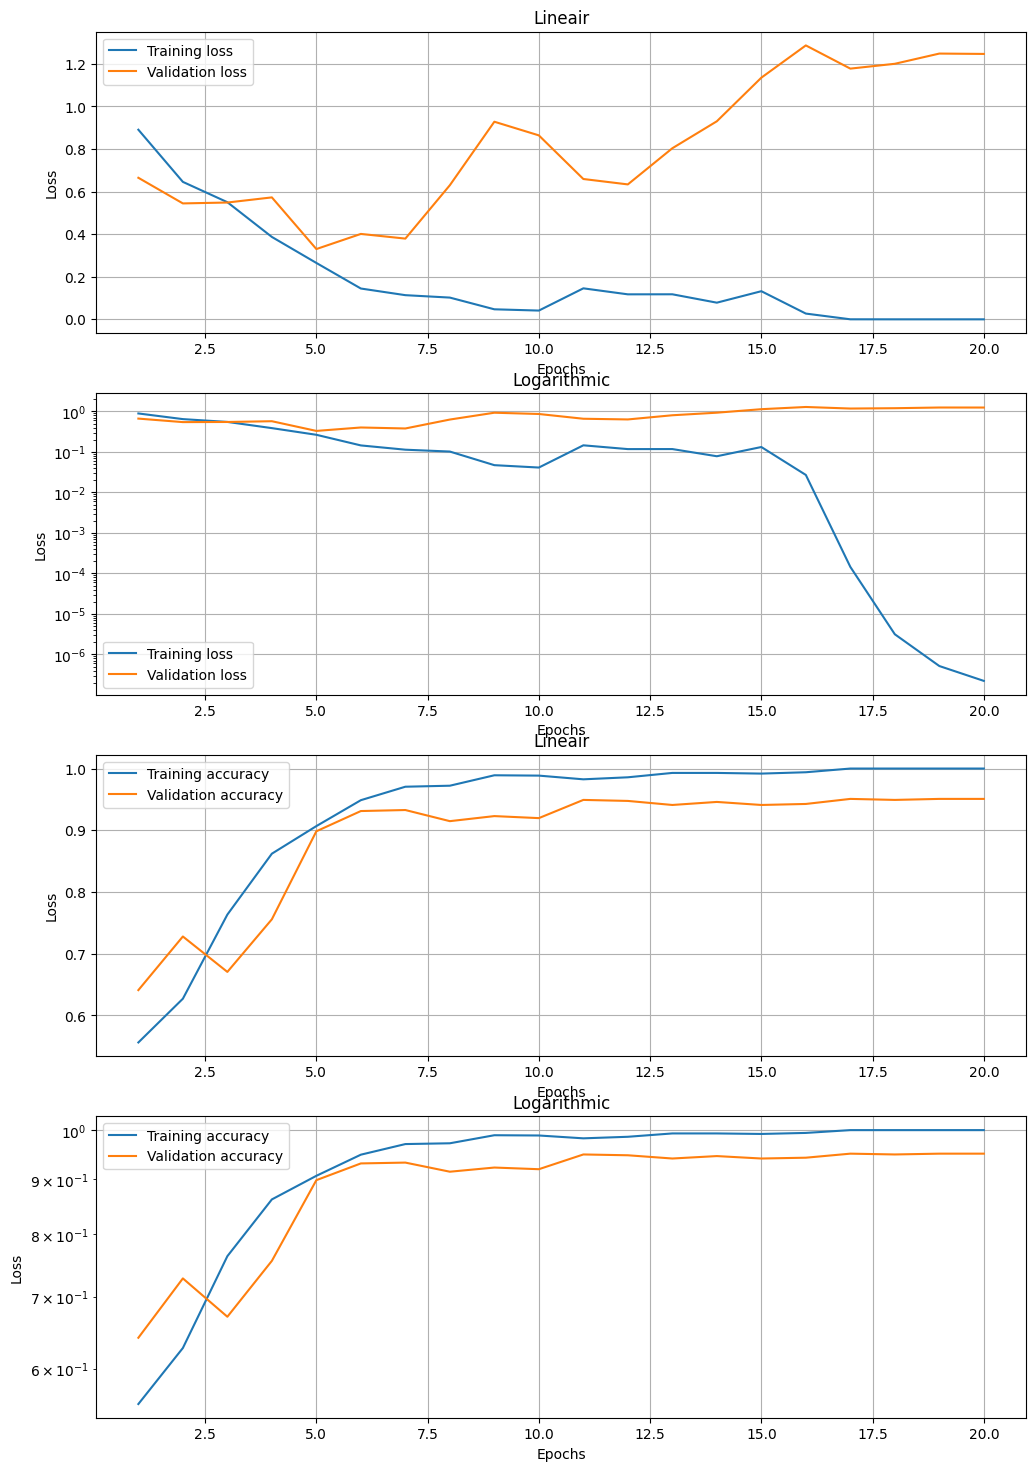

In [21]:
plot_loss(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
Accuracy:  0.6792452830188679
Recall:  0.7639344262295082
Precision:  0.8321428571428572
F1:  0.7965811965811966
ROC AUC:  0.525906607054148


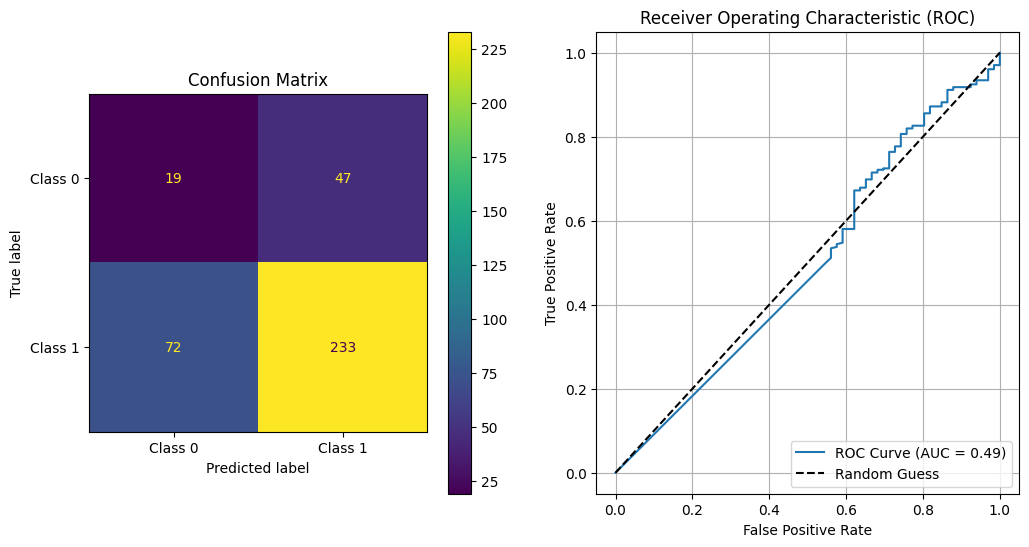

In [22]:
print_metrics(model, test)

Image size bepalen

In [24]:
statistics = ["min", "25%", "median", "mean", "75%"]
interpolations = ["bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian"]
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
painters = ["Mondriaan", "Picasso"]

results = []

for statistic in statistics:
    width = int(stats.loc[f"{statistic}", "widths"])
    height = int(stats.loc[f"{statistic}", "heights"])
    for interpolation in interpolations:
        print(statistic, interpolation)
        train, val, test = load_dataset(dataset_dir, painters, width, height, batch_size=16, interpolation=interpolation)
        model = build_model(width, height)
        model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
        callbacks = [keras.callbacks.ModelCheckpoint(filepath="gridsearch_model.keras", save_best_only=True, monitor="val_loss")]
        history = model.fit(train, epochs=15, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

        y_pred_prob = model.predict(test)
        y_pred = np.where(y_pred_prob > 0.5, 1, 0)
        y_true = np.concatenate([y.numpy() for _, y in test], axis=0)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        test_accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred_prob)
        
        results.append({
            "statistic": statistic,
            "interpolation": interpolation,
            "width": width,
            "height": height,
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc": auc_score
        })
        print(results[-1])

df = pd.DataFrame(results)

min bilinear
Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
{'statistic': 'min', 'interpolation': 'bilinear', 'width': 106, 'height': 108, 'train_accuracy': 0.9793722033500671, 'val_accuracy': 0.9249329566955566, 'test_accuracy': 0.6442048517520216, 'train_loss': 0.05422148108482361, 'val_loss': 0.2651461362838745, 'precision': 0.8145454545454546, 'recall': 0.7344262295081967, 'f1_score': 0.7724137931034483, 'auc': 0.4988077496274218}
min nearest
Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
{'statistic': 'min', 'interpolation': 'nearest', 'width': 106, 'height': 108, 'train_accuracy': 0.9829596281051636, 'val_accuracy': 0.9115281701087952, 'test_accuracy': 0.706199460916442, 'train_loss': 0.050010792911052704, 'val_loss': 0.3506341278553009, 'precision': 0.824

In [25]:
df.sort_values("test_accuracy", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,min,lanczos5,106,108,0.971300,0.847185,0.787062,0.079654,1.327850,0.822857,0.944262,0.879389,0.487953
21,mean,bilinear,603,648,0.975785,0.954424,0.727763,0.135400,0.500894,0.833333,0.836066,0.834697,0.531495
12,25%,lanczos5,314,383,0.960538,0.930295,0.716981,0.094464,0.302923,0.831126,0.822951,0.827018,0.543443
16,median,bicubic,550,590,0.970404,0.919571,0.714286,0.077738,0.536489,0.832776,0.816393,0.824503,0.497640
13,25%,gaussian,314,383,0.959641,0.957105,0.711590,0.105894,0.199140,0.827815,0.819672,0.823723,0.512643


In [26]:
df.sort_values("f1_score", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,min,lanczos5,106,108,0.971300,0.847185,0.787062,0.079654,1.327850,0.822857,0.944262,0.879389,0.487953
21,mean,bilinear,603,648,0.975785,0.954424,0.727763,0.135400,0.500894,0.833333,0.836066,0.834697,0.531495
12,25%,lanczos5,314,383,0.960538,0.930295,0.716981,0.094464,0.302923,0.831126,0.822951,0.827018,0.543443
16,median,bicubic,550,590,0.970404,0.919571,0.714286,0.077738,0.536489,0.832776,0.816393,0.824503,0.497640
6,min,gaussian,106,108,0.982063,0.949062,0.711590,0.077800,0.288918,0.825658,0.822951,0.824302,0.501664


In [31]:
df.sort_values("precision", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
20,median,gaussian,550,590,0.943498,0.734584,0.568733,0.196751,2.123221,0.846890,0.580328,0.688716,0.512022
25,mean,lanczos3,603,648,0.968610,0.900804,0.708895,0.325899,0.460274,0.845614,0.790164,0.816949,0.567437
18,median,lanczos3,550,590,0.971300,0.871314,0.649596,0.132244,0.799231,0.843137,0.704918,0.767857,0.540686
33,75%,lanczos5,800,826,0.965919,0.892761,0.700809,0.381046,0.825638,0.841549,0.783607,0.811545,0.566865
19,median,lanczos5,550,590,0.958744,0.898123,0.644205,0.269686,0.634379,0.833977,0.708197,0.765957,0.521038


In [32]:
df.sort_values("recall", ascending=False).head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
5,min,lanczos5,106,108,0.971300,0.847185,0.787062,0.079654,1.327850,0.822857,0.944262,0.879389,0.487953
21,mean,bilinear,603,648,0.975785,0.954424,0.727763,0.135400,0.500894,0.833333,0.836066,0.834697,0.531495
12,25%,lanczos5,314,383,0.960538,0.930295,0.716981,0.094464,0.302923,0.831126,0.822951,0.827018,0.543443
22,mean,nearest,603,648,0.976682,0.938338,0.700809,0.112956,0.364941,0.814935,0.822951,0.818923,0.483159
6,min,gaussian,106,108,0.982063,0.949062,0.711590,0.077800,0.288918,0.825658,0.822951,0.824302,0.501664


In [33]:
df.sort_values("val_loss").head(5)

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
4,min,lanczos3,106,108,0.974888,0.935657,0.695418,0.086248,0.173565,0.811688,0.819672,0.815661,0.473597
13,25%,gaussian,314,383,0.959641,0.957105,0.711590,0.105894,0.199140,0.827815,0.819672,0.823723,0.512643
11,25%,lanczos3,314,383,0.973991,0.951743,0.679245,0.110439,0.259940,0.812081,0.793443,0.802653,0.465474
0,min,bilinear,106,108,0.979372,0.924933,0.644205,0.054221,0.265146,0.814545,0.734426,0.772414,0.498808
8,25%,nearest,314,383,0.952466,0.949062,0.700809,0.143429,0.266810,0.823333,0.809836,0.816529,0.500000


In [34]:
df.to_csv("image_size_gridsearch_result.csv")